In [1]:
%load_ext autoreload
%autoreload 2

%load_ext dotenv
%dotenv

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os
from pathlib import Path

import itertools
import numpy as onp
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from dtd.utils import get_wnb_project_df

In [3]:
WNB_ENTITY = os.environ['WNB_ENTITY']
WNB_PROJECT = os.environ['WNB_PROJECT']

## Get results

In [4]:
def get_results(update: bool=False, filepath: str='results.csv'):
    """Get cross-validation results for project.

    If `update=True`, download results from . This can take several minutes.

    Parameters
    ----------
    filepath (str). Filepath that CSV results are stored in.
        Default: "results.csv", in the same directory as the notebook.
    update (bool). If True, download results from WandB server.
        Else, load results from local file, in 
        Default: False
    """
    
    if (update==False) and os.path.isfile(filepath):
        df = pd.read_csv(filepath)
    else:
        if (update==False) and (not os.path.isfile(filepath)):
            print("{filepath} does not exist, ignoring {update=}.")
        
        print(f"Downloading results from {WNB_ENTITY}/{WNB_PROJECT}. This can take a few minutes...")
        df = get_wnb_project_df(
            WNB_ENTITY, WNB_PROJECT,
            config_keys=['k1', 'k2', 'k3'],
            summary_keys=['avg_test_ll'],
            log_keys=['avg_lp.min'],
            timeout=120,
        )

        print(f"Done. Saving results to '{filepath}'.")
        df.to_csv(filepath, index=False)

    return df

df = get_results(update=False)
df

,id,name,k1,k2,k3,avg_test_ll,avg_lp.min
0,eukw0voq,trim-sweep-1,2,2,2,-29.222704,-35.488850
1,f20z9gmp,sage-sweep-2,2,2,4,-27.763206,-35.236946
2,ov0jy7yy,bumbling-sweep-3,2,2,8,-27.499195,-35.280354
3,p9ptkxce,fragrant-sweep-4,2,2,16,-27.474854,-35.027840
4,f03y8qor,dauntless-sweep-5,2,2,24,-27.237316,-34.701698
...,...,...,...,...,...,...,...
5949,j8yn3o0l,fluent-sweep-104,48,20,24,-19.431236,-34.552361
5950,llyebj0l,fine-sweep-105,48,20,36,-20.060795,-34.469254
5951,spl96phg,honest-sweep-106,48,20,48,-19.613855,-34.364029
5952,jalzt4ik,wobbly-sweep-107,48,20,72,-19.552197,-34.148777


In [5]:
df.groupby(['k1','k2','k3']).size().reset_index().rename(columns={0:'n_folds'})

,k1,k2,k3,n_folds
0,2,2,2,12
1,2,2,4,12
2,2,2,8,12
3,2,2,16,12
4,2,2,24,12
...,...,...,...,...
589,256,20,24,10
590,256,20,36,10
591,256,20,48,10
592,256,20,72,10


## Inspect held-out log likelihood curves

Here, we inspect the held-out log likelihood as a function of $k_1, k_2, \textrm{ and } k_3$ model parameters. For each choice of number of dynamic topics $k_1$, we aim to identify the most parismonious row and column ranks ($k_2, k_3$) for the dynamic topics.

Text(0.5, 1.05, 'held-out log likelihood vs. k1 vs. k2 vs. k3')

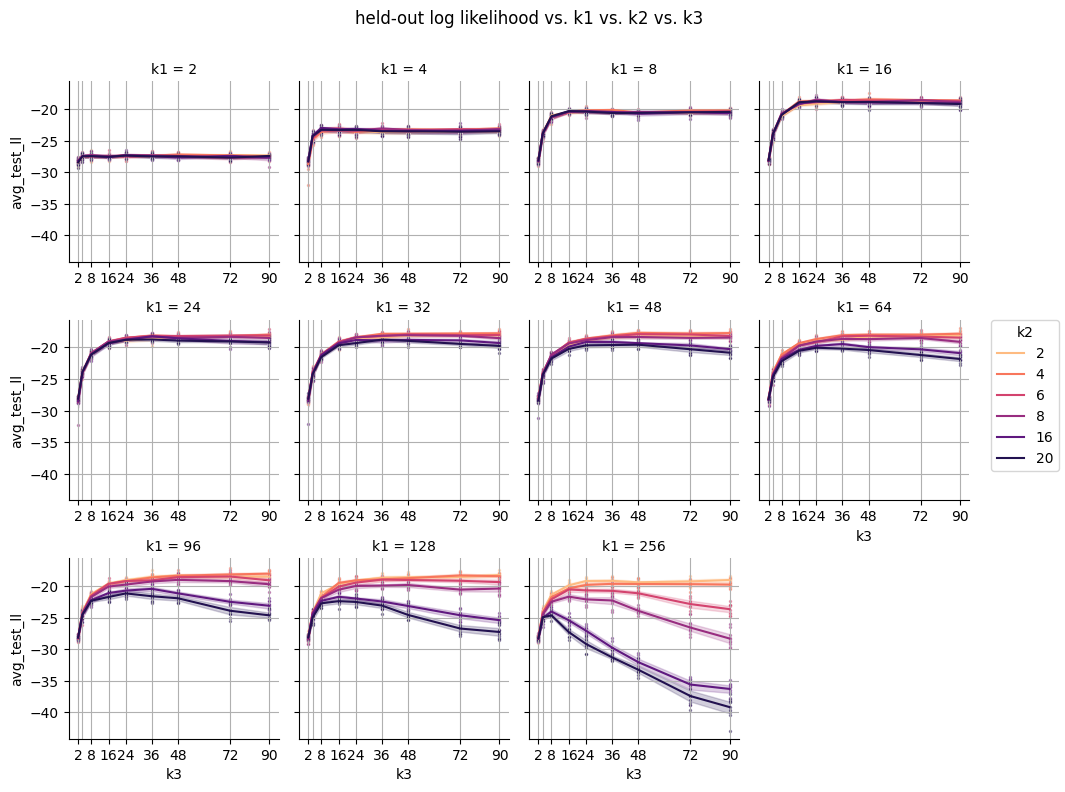

In [6]:
col_var = 'k1'
hue_var = 'k2'
x_var = 'k3'

g = sns.FacetGrid(df,
    col=col_var, col_wrap=4,
    hue=hue_var, palette="magma_r",
    sharex=False,
    height=2.5
)

g.map(sns.lineplot, x_var, "avg_test_ll")
g.add_legend(frameon=True)
g.map(sns.scatterplot, x_var, "avg_test_ll", markers='.', s=6, alpha=0.6)

# Set x ticks
all_xticks = df[x_var].unique()
for ax in g.axes:
    # Draw grid lines for all swept values, but only show ticks for a smaller set
    ax.set_xticks([2, 8, 16, 24, 36, 48, 72, 90])  # These are for x_var='k3'

    ax.set_xticks(all_xticks, minor=True)
    ax.tick_params(which='minor', bottom=False)
    ax.grid(which='both')

plt.gcf().suptitle('held-out log likelihood vs. k1 vs. k2 vs. k3', y=1.05)

Above, we can pick out the best $k_3$ value for every $k_1$. Below, we inspect average held-out log likelihood vs. $k2$ for a given pair of $(k_1, k_3)$ values.

Text(0.5, 1.0, 'avg test ll vs k2, for k1=32, k3=24')

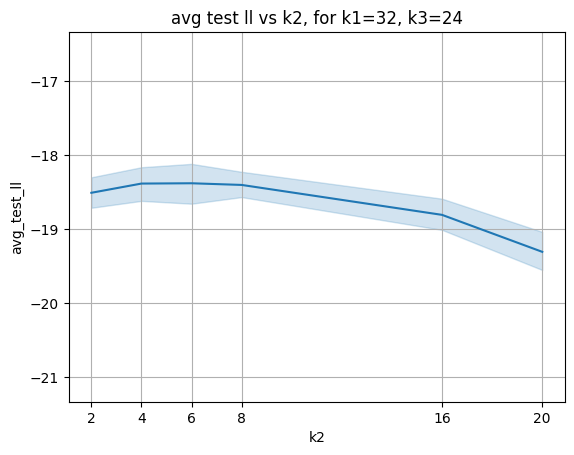

In [7]:
selected_k1, selected_k3 = 32, 24
subdf = df[(df['k1']==selected_k1) & (df['k3']==selected_k3)]
sns.lineplot(subdf, x='k2', y="avg_test_ll")

ax = plt.gca()
xticks = subdf['k2'].unique()
ax.set_xticks(xticks)
ax.set_xticklabels(xticks)
ax.grid()

ymin, ymax = ax.get_ylim()
ymid = (ymax + ymin) / 2
dy = ymax - ymin

if dy < (min_dy := 5):
    ax.set_ylim(ymid-min_dy/2, ymid+min_dy/2)

ax.set_title(f"avg test ll vs k2, for k1={selected_k1}, k3={selected_k3}")

Based on our visual inspects above, we can choose the most parsimonious $(k_2, k_3)$ values for a DTD model with a given number of dynamic topics.

In [8]:
# DTD ranks as a function of k1
selected_dtd_ranks = [
    (  2,  6,  4),
    (  4,  6,  8),
    (  8,  8, 16),
    ( 16,  8, 24),
    ( 24,  6, 24),
    ( 32,  6, 24),
    ( 48,  4, 36),
    ( 64,  4, 36),
    ( 96,  4, 48),
    (128,  2, 36),
    (256,  2, 24),
]

## Held-out log-likelihood vs. number of dynamic topics

In [9]:
selected_df = pd.concat([
    df[(df['k1']==k1) & (df['k2']==k2) & (df['k3']==k3)]
    for k1, k2, k3 in selected_dtd_ranks
])
selected_df

,id,name,k1,k2,k3,avg_test_ll,avg_lp.min
17,33x78079,flowing-sweep-20,2,6,4,-27.191872,-35.175381
498,7zcj6x9t,serene-sweep-20,2,6,4,-27.895266,-35.414852
982,bjb7g4b8,azure-sweep-20,2,6,4,-27.272648,-35.201164
1453,ofbv7mu5,azure-sweep-20,2,6,4,-27.513674,-35.081322
1463,n7rceg9k,fresh-sweep-20,2,6,4,-27.076181,-35.348492
...,...,...,...,...,...,...,...
4522,a690ajxd,visionary-sweep-437,256,2,24,-19.342869,-33.670349
4588,hc3oql2s,earthy-sweep-437,256,2,24,-18.524065,-34.073803
4614,9cut9roq,glamorous-sweep-437,256,2,24,-19.226147,-33.878601
4641,llzfnyoa,astral-sweep-437,256,2,24,-19.585857,-33.623882


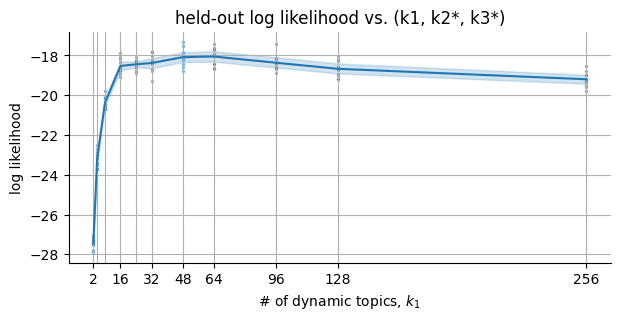

In [10]:
plt.figure(figsize=(7,3))
sns.lineplot(selected_df, x='k1', y='avg_test_ll')
sns.scatterplot(selected_df, x='k1', y='avg_test_ll', s=6, alpha=0.6)

ax = plt.gca()

ax.set_xticks([2, 16, 32, 48, 64, 96, 128, 256])

# Draw grid lines for all swept values, but do not show ticks
all_xticks = selected_df['k1'].unique()
ax.set_xticks(all_xticks, minor=True)
ax.tick_params(which='minor', bottom=False)

ax.grid(which='both')

ax.set_title("held-out log likelihood vs. (k1, k2*, k3*)")

ax.set_xlabel(r"# of dynamic topics, $k_1$")
ax.set_ylabel("log likelihood")

sns.despine()

Based on this value, we would select the most parsimonious model size to be $k_1=16$ dynamic topics.